In [1]:
import numpy as np
import time
from interface import ExoSkeletonUDPInterface
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
import pickle as pkl

import time

import vicon_sdk_cpp
from vicon_sdk_cpp import ViconClient, ViconFrame

In [2]:
# Connect to the server using a ViconClient.
client = ViconClient()
client.initialize("172.24.117.119:801")
client.run()

# Create a frame to hold the received data.
base_frame = ViconFrame()
shoulder_frame = ViconFrame()


Connecting to Vicon 172.24.117.119:801... 
Connected to Vicon System.
Warning this thread is not going to be real time.


True

In [4]:
client.get_vicon_frame("EXO_BASE/EXO_BASE", base_frame)
client.get_vicon_frame("EXO_ARM/EXO_ARM", shoulder_frame)

base_frame.se3_pose[3:]

array([-0.20920914,  0.52084828, -0.21888506,  0.79814656])

In [2]:
# with open("data/dataset1.pkl", "rb") as f:
#     data = pkl.load(f)

In [3]:
data_q = np.array(data["q"]).squeeze()/9
data_q -= np.mean(data_q[0:500])
data_shoulder = data["shoulder_T"]
data_arm = data["arm_T"]

In [4]:
angle_mat = []
invert_sign = -1
for i in range(len(data_shoulder)):
    T = np.linalg.inv(data_shoulder[i]) @ data_arm[i]
    T = T[0:3,0:3]
    angle = np.linalg.norm(Rotation.from_matrix(T).as_rotvec())
    ## Flipping sign of the vicon measured angle because rotvec is between 0-180. By flipping it goes from -180-180.
    if i == 6795 or  i == 7750:
        invert_sign *= -1

    if invert_sign == 1:
        angle *=-1

    angle_mat.append(angle)

angle_mat = np.asarray(angle_mat)

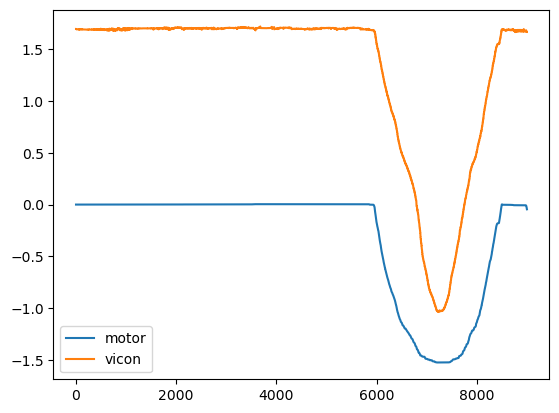

In [5]:
start = 0
end = 9000
plt.plot(data_q[start:end], label = "motor")
plt.plot(angle_mat[start:end], label = "vicon")
plt.legend()
# plt.plot(data_q, angle_mat)

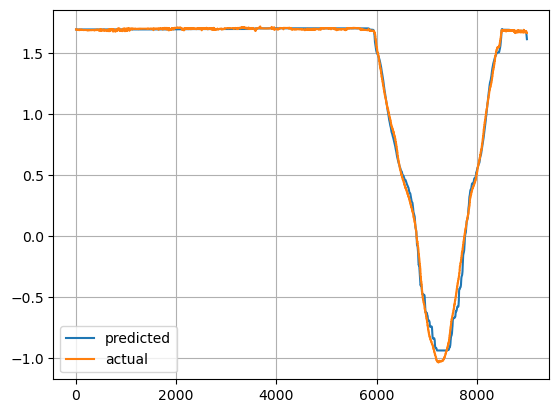

In [12]:
poly_coef = np.polyfit(np.array(data_q[start:end]).squeeze(), angle_mat[start:end], 5)
test = np.polyval(poly_coef, np.array(data_q).squeeze())
plt.plot(test[start:end], label="predicted")
plt.plot(angle_mat[start:end], label = "actual")
plt.legend()
plt.grid()

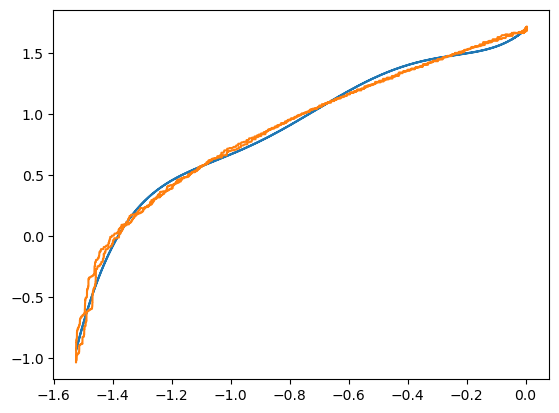

In [13]:
plt.plot(data_q[start:end], test[start:end])
plt.plot(data_q[start:end], angle_mat[start:end])

In [28]:
with open("data/dataset2.pkl", "rb") as f:
    data_test = pkl.load(f)

data_q = np.array(data_test["q"]).squeeze()/9
data_q -= np.mean(data_q[0:500])
data_shoulder = data_test["shoulder_T"]
data_arm = data_test["arm_T"]

In [29]:
angle_mat = []
for i in range(len(data_shoulder)):
    T = np.linalg.inv(data_shoulder[i]) @ data_arm[i]
    T = T[0:3,0:3]
    angle = Rotation.from_matrix(T).as_rotvec()
    angle_mat.append(np.linalg.norm(angle))

angle_mat = np.asarray(angle_mat)

In [30]:
test = np.polyval(poly_coef, np.array(data_q).squeeze())
plt.plot(angle_mat, label = "actual")
plt.plot(test, label="predicted")
plt.legend()
plt.grid()

In [27]:
poly_coef

array([ 5.16039797, 17.20853557, 20.02039048,  9.07187824,  2.124709  ,
        1.69513506])